In [1]:
import geojson
import geopandas as gpd
import descarteslabs as dl
import pandas as pd
from shapely import geometry
import numpy as np
import json
import yaml
import pickle
import matplotlib.pyplot as plt

- Combine airbus and cv polygons
- get S2-shaped tiles for all polygons
- filter those tiles for only those within airbus tiles

In [2]:
cv_tiles = gpd.read_file('../data/cv_all_tiles.geojson')
cv_polys = gpd.read_file('../data/cv_all_polys.geojson')

In [19]:
cv_polys_mp = geometry.MultiPolygon([geom for geom in cv_polys.unary_union.geoms])

In [49]:
cv_tiles_mp =geometry.MultiPolygon([geom for geom in cv_tiles.unary_union.geoms])

### Download pipeline interim features

In [2]:
config = yaml.safe_load(open('../cloud_products_exec.yaml','r'))

In [12]:
for kk in config.keys():
    print (config[kk]['cloud_id'])

ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v1-solar-pv-20190521-combined-final
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:solar_pv_S2_v3_20190306_primary
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:solar_pv:s2:v3_20190327:secondary
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:V1-solar_pv-S2-20190308-primary_pass
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:V2-solar_pv-S2-20190327-secondary_filter
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:V3-solar_pv-S2-20190328-deepstack
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v4-solar_pv-s2-20190322_final
8514dad6c277e007cedb6fb8e829a23c8975fca4:solar_pv:airbus:spot:v5_0111
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v1b-solar-pv-spot
ba611607613832ad7bb8fa9dc2bafb71f693bd6a:v1-solar_pv-spot-20200317-postfilter


In [3]:
vector_keys = [kk for kk in config.keys() if kk.split('-')[1][0]=='V']

In [4]:
vector_keys=vector_keys[1:]

In [5]:
vector_keys

['S2-V1-Primary',
 'S2-V2-Secondary',
 'S2-V3-Deepstack',
 'S2-V4-Final',
 'SPOT-V1-Vectorised',
 'SPOT-V2-Filtered']

In [55]:
for kk in vector_keys:
    fc = dl.vectors.FeatureCollection(config[kk]['cloud_id'])
    fts = [geojson.Feature(geometry=f.geometry, properties=f.properties) for f in fc.filter(cv_tiles_mp).features()]
    print (kk, len(fts))
    json.dump(geojson.FeatureCollection(fts),open('../data/crossvalidation/'+kk+'.geojson','w'))

S2-V1-Primary 2365
S2-V2-Secondary 2311
S2-V3-Deepstack 882
S2-V4-Final 449
SPOT-V1-Vectorised 1095
SPOT-V2-Filtered 398


### Get final product

In [5]:
final_polys=gpd.read_file('../data/ABCD_simplified.geojson')

In [7]:
final_polys = final_polys[final_polys.intersects(cv_mp)]

In [45]:
final_polys.to_file('../data/crossvalidation/compile_final.geojson',driver='GeoJSON')

### Load downloaded features

In [6]:
gdfs = {}
for kk in vector_keys:
    gdfs[kk] = gpd.read_file('../data/crossvalidation/'+kk+'.geojson')
gdfs['compiled_final']=gpd.read_file('../data/crossvalidation/compile_final.geojson')

In [62]:
cv_polys['geoarea'] = cv_polys.to_crs({'init': 'epsg:3857'}).area

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [57]:
for kk in gdfs.keys():
    gdfs[kk]['geoarea'] = gdfs[kk].to_crs({'init': 'epsg:3857'}).area

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization metho

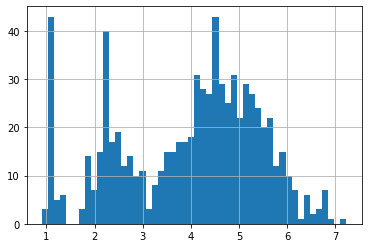

In [62]:
np.log10(gdfs['S2-V1-Primary']['geoarea']).hist(bins=50)

### precision / recall

In [7]:
area_bins = [0,1e2,1e3,1e4,1e5,1e6,1e10]

In [ ]:
res_dict= {}

In [63]:

for kk,gdf in gdfs.items():
    res_dict[kk] = {}
    pipe_mp = geometry.MultiPolygon([geom for geom in gdf.unary_union.geoms])
    for ii_a in range(len(area_bins)-1):
        res_dict[kk][ii_a] = {}
        # precision = TP/(TP+FP)
        bin_slice = gdf[(gdf.geoarea>=area_bins[ii_a]) & (gdf.geoarea<area_bins[ii_a+1])]
        intersects = bin_slice.intersects(cv_polys_mp)
        TP = np.sum(intersects)
        FP = np.sum(~intersects)
        res_dict[kk][ii_a]['P']=TP/(TP+FP)
        res_dict[kk][ii_a]['P_TP'] = TP
        res_dict[kk][ii_a]['P_FP'] = FP
        
        # recall = TP / (TP+FN)
        cv_slice = cv_polys[(cv_polys.geoarea>=area_bins[ii_a])&(cv_polys.geoarea<area_bins[ii_a+1])]
        intersects = cv_slice.intersects(pipe_mp)
        TP = np.sum(intersects)
        FN = np.sum(~intersects)
        res_dict[kk][ii_a]['R']=TP/(TP+FN)
        res_dict[kk][ii_a]['R_TP'] = TP
        res_dict[kk][ii_a]['R_FN'] = FN
        
        
        print (kk,area_bins[ii_a],res_dict[kk][ii_a])


S2-V1-Primary 0 {'P': 0.10443864229765012, 'P_TP': 80, 'P_FP': 686, 'R': 0.0462046204620462, 'R_TP': 112, 'R_FN': 2312}
S2-V1-Primary 100.0 {'P': 0.17724867724867724, 'P_TP': 134, 'P_FP': 622, 'R': 0.25051334702258726, 'R_TP': 488, 'R_FN': 1460}
S2-V1-Primary 1000.0 {'P': 0.3116883116883117, 'P_TP': 96, 'P_FP': 212, 'R': 0.34903381642512077, 'R_TP': 289, 'R_FN': 539}
S2-V1-Primary 10000.0 {'P': 0.7539936102236422, 'P_TP': 236, 'P_FP': 77, 'R': 0.9115191986644408, 'R_TP': 546, 'R_FN': 53}
S2-V1-Primary 100000.0 {'P': 0.8817204301075269, 'P_TP': 164, 'P_FP': 22, 'R': 0.9814385150812065, 'R_TP': 423, 'R_FN': 8}
S2-V1-Primary 1000000.0 {'P': 0.9444444444444444, 'P_TP': 34, 'P_FP': 2, 'R': 1.0, 'R_TP': 51, 'R_FN': 0}
S2-V2-Secondary 0 {'P': 0.13865546218487396, 'P_TP': 132, 'P_FP': 820, 'R': 0.04537953795379538, 'R_TP': 110, 'R_FN': 2314}
S2-V2-Secondary 100.0 {'P': 0.2108843537414966, 'P_TP': 62, 'P_FP': 232, 'R': 0.2464065708418891, 'R_TP': 480, 'R_FN': 1468}
S2-V2-Secondary 1000.0 {'P': 

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


SPOT-V1-Vectorised 0 {'P': nan, 'P_TP': 0, 'P_FP': 0, 'R': 0.033003300330033, 'R_TP': 80, 'R_FN': 2344}
SPOT-V1-Vectorised 100.0 {'P': 0.38461538461538464, 'P_TP': 20, 'P_FP': 32, 'R': 0.17813141683778233, 'R_TP': 347, 'R_FN': 1601}
SPOT-V1-Vectorised 1000.0 {'P': 0.49015748031496065, 'P_TP': 249, 'P_FP': 259, 'R': 0.36835748792270534, 'R_TP': 305, 'R_FN': 523}
SPOT-V1-Vectorised 10000.0 {'P': 0.7549857549857549, 'P_TP': 265, 'P_FP': 86, 'R': 0.6477462437395659, 'R_TP': 388, 'R_FN': 211}
SPOT-V1-Vectorised 100000.0 {'P': 0.8819875776397516, 'P_TP': 142, 'P_FP': 19, 'R': 0.6890951276102089, 'R_TP': 297, 'R_FN': 134}
SPOT-V1-Vectorised 1000000.0 {'P': 0.8260869565217391, 'P_TP': 19, 'P_FP': 4, 'R': 0.6078431372549019, 'R_TP': 31, 'R_FN': 20}
SPOT-V2-Filtered 0 {'P': nan, 'P_TP': 0, 'P_FP': 0, 'R': 0.010726072607260726, 'R_TP': 26, 'R_FN': 2398}
SPOT-V2-Filtered 100.0 {'P': 0.5625, 'P_TP': 9, 'P_FP': 7, 'R': 0.09034907597535935, 'R_TP': 176, 'R_FN': 1772}
SPOT-V2-Filtered 1000.0 {'P': 0.7

In [86]:
crs = CRS("EPSG:4326")

In [93]:
# iou
iou_dict = {}
for kk,gdf in gdfs.items():
    iou_dict[kk] = {}
    #pipe_mp = geometry.MultiPolygon([geom for geom in gdf.unary_union.geoms])
    for ii_a in range(len(area_bins)-1):
        iou_dict[kk][ii_a] = {}
        # iou = intersection / union
        bindf_slice = gdf[(gdf.geoarea>=area_bins[ii_a]) & (gdf.geoarea<area_bins[ii_a+1])]
        bindf_mp = geometry.MultiPolygon([geom for geom in bindf_slice.unary_union.geoms])
        cv_slice = cv_polys[(cv_polys.geoarea>=area_bins[ii_a])&(cv_polys.geoarea<area_bins[ii_a+1])]
        cv_mp = geometry.MultiPolygon([geom for geom in cv_slice.unary_union.geoms])
        
        intersection=bindf_mp.intersection(cv_mp)
        union=bindf_mp.union(cv_mp)
        

        if not intersection.is_empty:
            #print (intersection)
        
            if intersection.type=='Polygon':
                
                i_gdf = gpd.GeoDataFrame(geometry=[intersection], crs=crs)
            else:
                i_gdf = gpd.GeoDataFrame(geometry=list(intersection), crs=crs)

            if union.type=='Polygon':
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)
            else:
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)

            i_gdf['geoarea'] = i_gdf.to_crs({'init': 'epsg:3857'}).area
            u_gdf['geoarea'] = u_gdf.to_crs({'init': 'epsg:3857'}).area

            iou_dict[kk][ii_a]['iou'] = i_gdf['geoarea'].sum() / u_gdf['geoarea'].sum()
            
        else:
            iou_dict[kk][ii_a]['iou'] = 0
        
        
        print (kk,area_bins[ii_a],iou_dict[kk][ii_a])

S2-V1-Primary 0 {'iou': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 100.0 {'iou': 0.000575957496241044}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 1000.0 {'iou': 0.04458308022227081}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 10000.0 {'iou': 0.25633016597675484}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 100000.0 {'iou': 0.34174840993048716}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 1000000.0 {'iou': 0.33652392593238295}
S2-V2-Secondary 0 {'iou': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 100.0 {'iou': 0.00013033784295686285}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 1000.0 {'iou': 0.04994825911492288}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 10000.0 {'iou': 0.26483324892686544}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 100000.0 {'iou': 0.3463247263440033}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 1000000.0 {'iou': 0.3380914159406726}
S2-V3-Deepstack 0 {'iou': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 100.0 {'iou': 0.00014645965677867912}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 1000.0 {'iou': 0.026523989020220066}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 10000.0 {'iou': 0.2538674717770279}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 100000.0 {'iou': 0.34418893969466247}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 1000000.0 {'iou': 0.36418741350545997}
S2-V4-Final 0 {'iou': 0}
S2-V4-Final 100.0 {'iou': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 1000.0 {'iou': 0.010597805804867692}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 10000.0 {'iou': 0.21697762323230407}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 100000.0 {'iou': 0.3251610000423048}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 1000000.0 {'iou': 0.34457205068514934}
SPOT-V1-Vectorised 0 {'iou': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 100.0 {'iou': 0.0010722983157028575}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 1000.0 {'iou': 0.08083197614917767}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 10000.0 {'iou': 0.2042919724027484}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 100000.0 {'iou': 0.2510751272995275}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 1000000.0 {'iou': 0.15877729607232258}
SPOT-V2-Filtered 0 {'iou': 0}
SPOT-V2-Filtered 100.0 {'iou': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V2-Filtered 1000.0 {'iou': 0.09073842919416483}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V2-Filtered 10000.0 {'iou': 0.1293949334832582}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization metho

SPOT-V2-Filtered 100000.0 {'iou': 0.16189535565364738}
SPOT-V2-Filtered 1000000.0 {'iou': 0.1182578450426753}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 0 {'iou': 0}
compiled_final 100.0 {'iou': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 1000.0 {'iou': 0.06168309019793569}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 10000.0 {'iou': 0.3176283773378961}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 100000.0 {'iou': 0.47410073426891675}
compiled_final 1000000.0 {'iou': 0.5187973369269772}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [95]:
for kk,gdf in gdfs.items():
    #pipe_mp = geometry.MultiPolygon([geom for geom in gdf.unary_union.geoms])
    for ii_a in range(len(area_bins)-1):
        # iou = intersection / union
        bindf_slice = gdf[gdf.geoarea<area_bins[ii_a+1]]
        bindf_mp = geometry.MultiPolygon([geom for geom in bindf_slice.unary_union.geoms])
        cv_slice = cv_polys[cv_polys.geoarea<area_bins[ii_a+1]]
        cv_mp = geometry.MultiPolygon([geom for geom in cv_slice.unary_union.geoms])
        
        intersection=bindf_mp.intersection(cv_mp)
        union=bindf_mp.union(cv_mp)
        

        if not intersection.is_empty:
            #print (intersection)
        
            if intersection.type=='Polygon':
                
                i_gdf = gpd.GeoDataFrame(geometry=[intersection], crs=crs)
            else:
                i_gdf = gpd.GeoDataFrame(geometry=list(intersection), crs=crs)

            if union.type=='Polygon':
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)
            else:
                u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)

            i_gdf['geoarea'] = i_gdf.to_crs({'init': 'epsg:3857'}).area
            u_gdf['geoarea'] = u_gdf.to_crs({'init': 'epsg:3857'}).area

            iou_dict[kk][ii_a]['iou_neg'] = i_gdf['geoarea'].sum() / u_gdf['geoarea'].sum()
            
        else:
            iou_dict[kk][ii_a]['iou_neg'] = 0
        
        
        print (kk,area_bins[ii_a],iou_dict[kk][ii_a])

S2-V1-Primary 0 {'iou': 0, 'iou_pos': 0.6563800682850637, 'iou_neg': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 100.0 {'iou': 0.000575957496241044, 'iou_pos': 0.6565955418276836, 'iou_neg': 0.0005787945344644309}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 1000.0 {'iou': 0.04458308022227081, 'iou_pos': 0.6573135120645237, 'iou_neg': 0.038873578276106074}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 10000.0 {'iou': 0.25633016597675484, 'iou_pos': 0.6601423430244804, 'iou_neg': 0.25495086636237196}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 100000.0 {'iou': 0.34174840993048716, 'iou_pos': 0.6440034887939549, 'iou_neg': 0.3707904485204816}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 1000000.0 {'iou': 0.33652392593238295, 'iou_pos': 0.33652392593238295, 'iou_neg': 0.6563800682850637}
S2-V2-Secondary 0 {'iou': 0, 'iou_pos': 0.6582743554078028, 'iou_neg': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 100.0 {'iou': 0.00013033784295686285, 'iou_pos': 0.6584824566415236, 'iou_neg': 0.00020090324893347255}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 1000.0 {'iou': 0.04994825911492288, 'iou_pos': 0.6591570460551603, 'iou_neg': 0.04454032450030452}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 10000.0 {'iou': 0.26483324892686544, 'iou_pos': 0.6620476772423984, 'iou_neg': 0.2671084987063852}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 100000.0 {'iou': 0.3463247263440033, 'iou_pos': 0.6464954092969896, 'iou_neg': 0.3759693290847255}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 1000000.0 {'iou': 0.3380914159406726, 'iou_pos': 0.3380914159406726, 'iou_neg': 0.6582743554078028}
S2-V3-Deepstack 0 {'iou': 0, 'iou_pos': 0.6314645374110316, 'iou_neg': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 100.0 {'iou': 0.00014645965677867912, 'iou_pos': 0.6316433898157164, 'iou_neg': 0.0002263321361927507}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 1000.0 {'iou': 0.026523989020220066, 'iou_pos': 0.6322469835693977, 'iou_neg': 0.02242910610577691}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 10000.0 {'iou': 0.2538674717770279, 'iou_pos': 0.6349789967074572, 'iou_neg': 0.25198961171372053}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 100000.0 {'iou': 0.34418893969466247, 'iou_pos': 0.6175072826266965, 'iou_neg': 0.3709786551197132}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 1000000.0 {'iou': 0.36418741350545997, 'iou_pos': 0.36418741350545997, 'iou_neg': 0.6314645374110316}
S2-V4-Final 0 {'iou': 0, 'iou_pos': 0.6181663423445196, 'iou_neg': 0}
S2-V4-Final 100.0 {'iou': 0, 'iou_pos': 0.6183780011814288, 'iou_neg': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 1000.0 {'iou': 0.010597805804867692, 'iou_pos': 0.6192868158716925, 'iou_neg': 0.008583336525296244}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 10000.0 {'iou': 0.21697762323230407, 'iou_pos': 0.6231999621351502, 'iou_neg': 0.20497949894599457}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 100000.0 {'iou': 0.3251610000423048, 'iou_pos': 0.6057154492031507, 'iou_neg': 0.34717808412832657}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 1000000.0 {'iou': 0.34457205068514934, 'iou_pos': 0.34457205068514934, 'iou_neg': 0.6181663423445196}
SPOT-V1-Vectorised 0 {'iou': 0, 'iou_pos': 0.36967683216591196, 'iou_neg': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 100.0 {'iou': 0.0010722983157028575, 'iou_pos': 0.3698028181274525, 'iou_neg': 0.0009370837797956577}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 1000.0 {'iou': 0.08083197614917767, 'iou_pos': 0.37015804318879225, 'iou_neg': 0.07480765979712506}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 10000.0 {'iou': 0.2042919724027484, 'iou_pos': 0.3695013576278666, 'iou_neg': 0.2131743281807967}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 100000.0 {'iou': 0.2510751272995275, 'iou_pos': 0.3411494214135542, 'iou_neg': 0.28199077091666935}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 1000000.0 {'iou': 0.15877729607232258, 'iou_pos': 0.15877729607232258, 'iou_neg': 0.36967683216591196}
SPOT-V2-Filtered 0 {'iou': 0, 'iou_pos': 0.15876753036408528, 'iou_neg': 0}
SPOT-V2-Filtered 100.0 {'iou': 0, 'iou_pos': 0.15883094411367074, 'iou_neg': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V2-Filtered 1000.0 {'iou': 0.09073842919416483, 'iou_pos': 0.1589683788322504, 'iou_neg': 0.08075309067133665}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V2-Filtered 10000.0 {'iou': 0.1293949334832582, 'iou_pos': 0.1565628288469313, 'iou_neg': 0.14323632123539198}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V2-Filtered 100000.0 {'iou': 0.16189535565364738, 'iou_pos': 0.14612575499090605, 'iou_neg': 0.17775850237654597}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V2-Filtered 1000000.0 {'iou': 0.1182578450426753, 'iou_pos': 0.1182578450426753, 'iou_neg': 0.15876753036408528}
compiled_final 0 {'iou': 0, 'iou_pos': 0.660817667864235, 'iou_neg': 0}
compiled_final 100.0 {'iou': 0, 'iou_pos': 0.6610696421112114, 'iou_neg': 0}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 1000.0 {'iou': 0.06168309019793569, 'iou_pos': 0.6619465507861063, 'iou_neg': 0.05221621201875168}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 10000.0 {'iou': 0.3176283773378961, 'iou_pos': 0.6646446098512561, 'iou_neg': 0.30994891667903485}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 100000.0 {'iou': 0.47410073426891675, 'iou_pos': 0.6500586411565747, 'iou_neg': 0.4993791527774188}


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 1000000.0 {'iou': 0.5187973369269772, 'iou_pos': 0.5187973369269772, 'iou_neg': 0.660817667864235}


In [101]:
pickle.dump(iou_dict, open('../data/iou_dict.pickle','wb'))

In [100]:
iou_dict

{'S2-V1-Primary': {0: {'iou': 0, 'iou_pos': 0.6563800682850637, 'iou_neg': 0},
  1: {'iou': 0.000575957496241044,
   'iou_pos': 0.6565955418276836,
   'iou_neg': 0.0005787945344644309},
  2: {'iou': 0.04458308022227081,
   'iou_pos': 0.6573135120645237,
   'iou_neg': 0.038873578276106074},
  3: {'iou': 0.25633016597675484,
   'iou_pos': 0.6601423430244804,
   'iou_neg': 0.25495086636237196},
  4: {'iou': 0.34174840993048716,
   'iou_pos': 0.6440034887939549,
   'iou_neg': 0.3707904485204816},
  5: {'iou': 0.33652392593238295,
   'iou_pos': 0.33652392593238295,
   'iou_neg': 0.6563800682850637},
  'full': 0.6563800682850637},
 'S2-V2-Secondary': {0: {'iou': 0,
   'iou_pos': 0.6582743554078028,
   'iou_neg': 0},
  1: {'iou': 0.00013033784295686285,
   'iou_pos': 0.6584824566415236,
   'iou_neg': 0.00020090324893347255},
  2: {'iou': 0.04994825911492288,
   'iou_pos': 0.6591570460551603,
   'iou_neg': 0.04454032450030452},
  3: {'iou': 0.26483324892686544,
   'iou_pos': 0.6620476772423984

### Plot Data

In [8]:
res_dict = pickle.load(open('../data/res_dict.pkl','rb'))
iou_dict = pickle.load(open('../data/iou_dict.pickle','rb'))

In [9]:
for key, vv in res_dict.items():
    for ar,vv2 in vv.items():
        vv2['iou'] = iou_dict[key][ar]['iou']
        vv2['iou_neg'] = iou_dict[key][ar]['iou_neg']
        vv2['iou_pos'] = iou_dict[key][ar]['iou_pos']

In [10]:
from matplotlib.collections import LineCollection

In [28]:
title_dict = {'P':'Precision','R':'Recall','iou_neg':'Intersection-over-Union'}

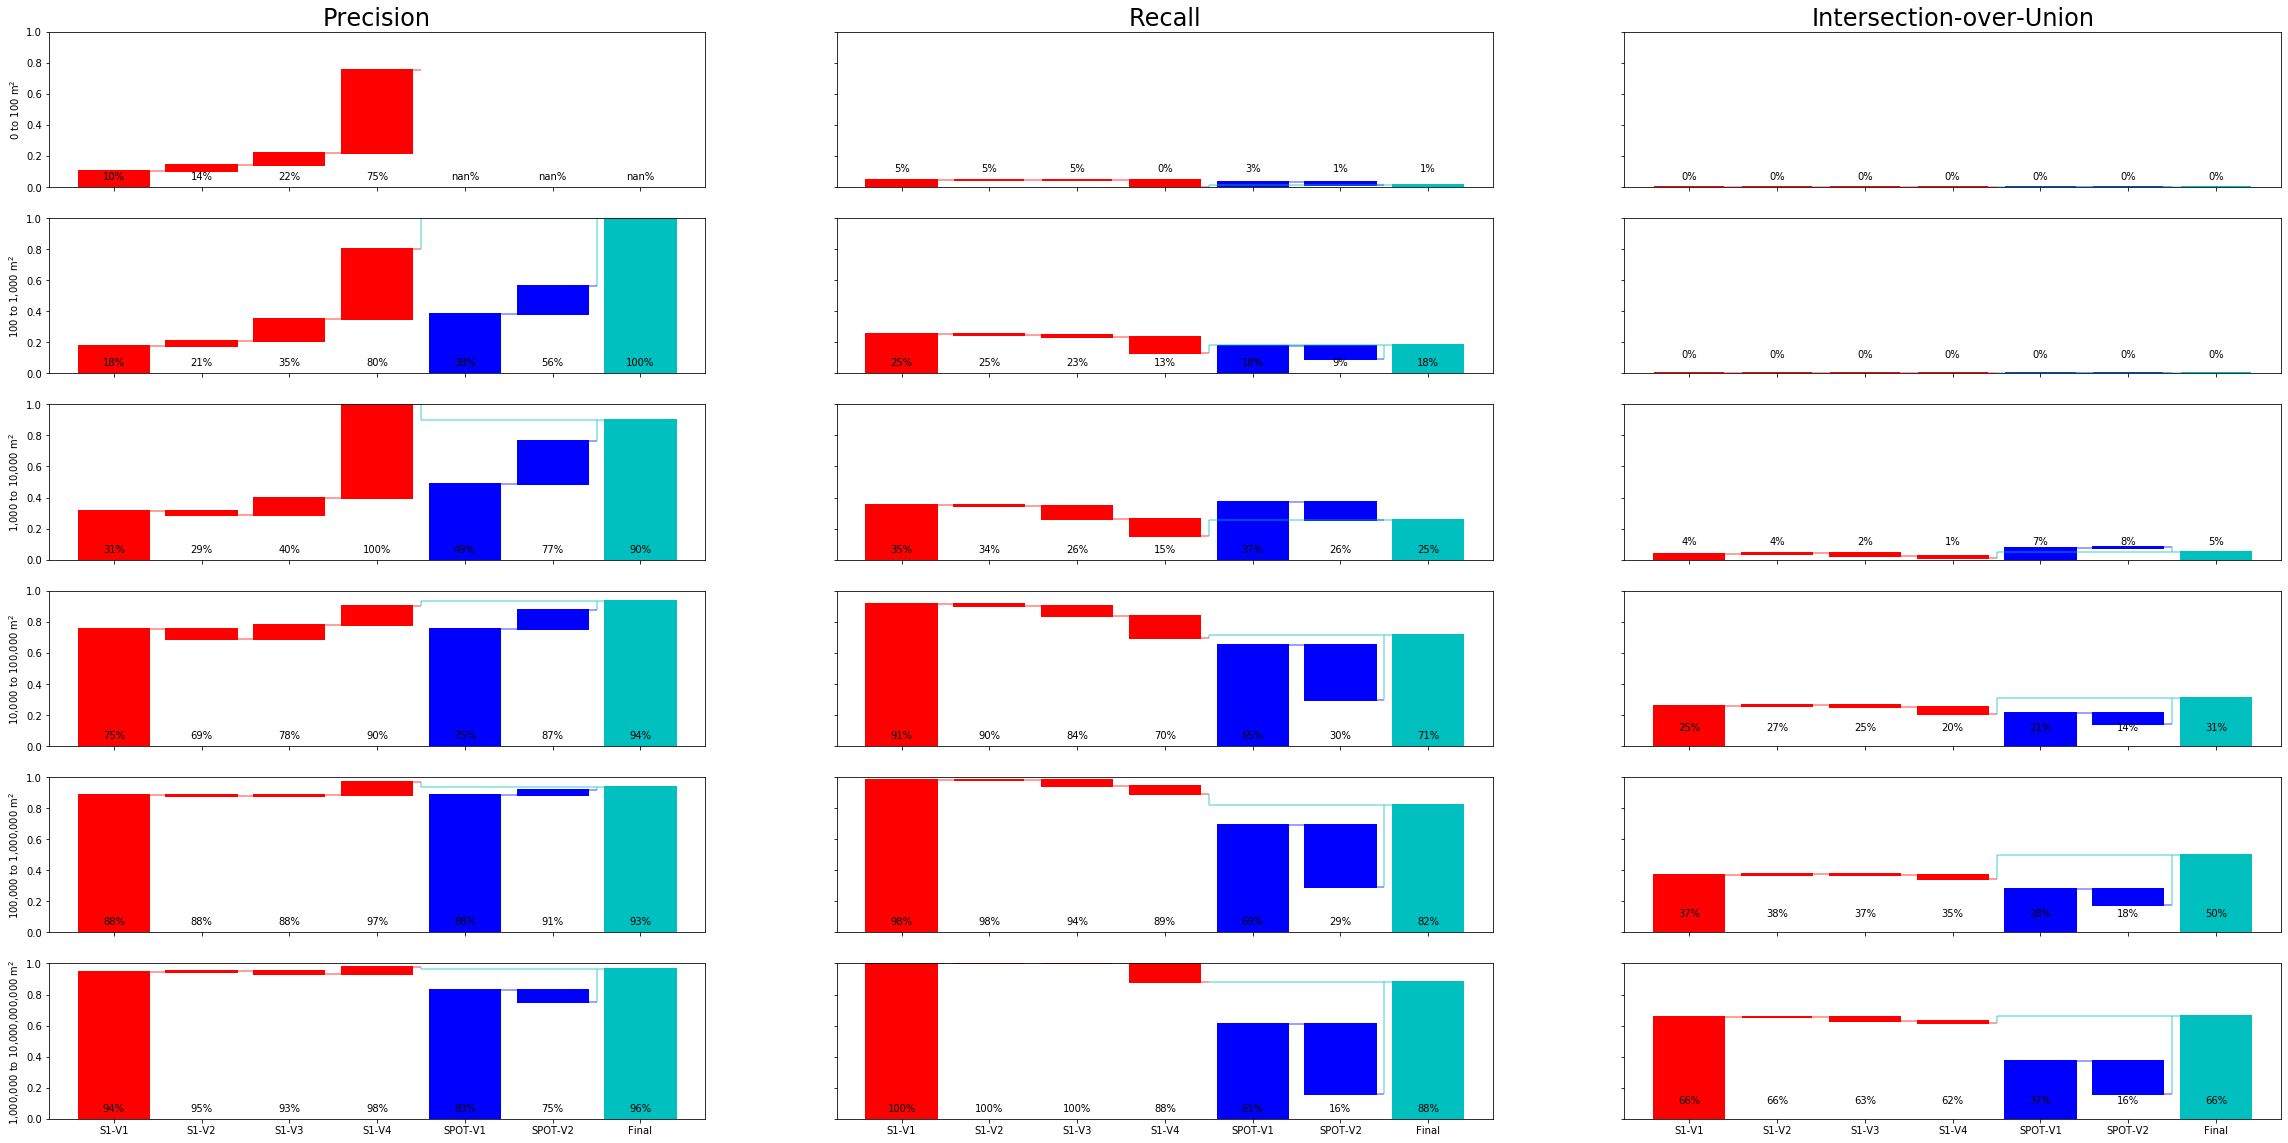

In [50]:
fig, axs = plt.subplots(len(area_bins)-1,3,figsize=(40,20),sharey=True, sharex=True)
# plot P
for ii_a in range(len(area_bins)-1):
    
    for ii_ax, M in enumerate(['P','R','iou_neg']):
        full_bars= [res_dict[kk][ii_a][M] for kk in gdfs.keys()] 

        bars = [full_bars[0]] + \
            [(full_bars[ii] - full_bars[ii-1]) for ii in range(1,4)] + \
            [full_bars[4], full_bars[5]-full_bars[4]] +\
            [full_bars[6]]
        bottoms = [0]+\
                    [full_bars[ii-1] for ii in range(1,4)] +\
                    [0,full_bars[4],0]
        
        lines_y = [el for el in full_bars for _ in (0,1)]
        lines_x = [0] + [el for el in range(1,6) for _ in (0,1)] + [6]
        segs = [[[lines_x[ii], lines_y[ii]],[lines_x[ii+1],lines_y[ii+1]]] for ii in range(0,12,2)]
        
        segs[3][1][0]=3.5
        segs[5][1][0]=5.5
        segs.append([segs[3][1],[segs[3][1][0],full_bars[6]]])
        segs.append([[segs[3][1][0],full_bars[6]],[6,full_bars[6]]])
        segs.append([segs[5][1],[segs[5][1][0],full_bars[6]]])
        
        
        line_segments = LineCollection(segs, colors=['r']*4 + ['b']*2 + ['c']*3, alpha=0.5)
        axs[ii_a,ii_ax].add_collection(line_segments)

        colors = ['r']*4 + ['b']*2 + ['c']


        axs[ii_a,ii_ax].bar(range(len(gdfs.keys())),bars, bottom=bottoms, edgecolor=colors, linewidth=2,color=colors)
        
        for ii in range(7):
            H=0.05
            if ((M=='R' and ii_a==0) or (M=='iou_neg' and ii_a)):
                H=.1
                
            axs[ii_a,ii_ax].text(ii,H,f'{full_bars[ii]:.0%}', horizontalalignment='center')

        
        axs[ii_a,ii_ax].set_xticklabels(['','S1-V1','S1-V2','S1-V3','S1-V4','SPOT-V1','SPOT-V2','Final'])
        
        if ii_a==0:
            axs[ii_a,ii_ax].set_title(title_dict[M],fontsize=24)
            axs[ii_a,ii_ax].set_ylim([0,1])
        
    axs[ii_a,0].set_ylabel(f'{area_bins[ii_a]:,.0f} to {area_bins[ii_a+1]:,.0f} m$^2$')
    
fig.savefig('../analysis/P-R-iou.png')

In [99]:
# big ious
for kk,gdf in gdfs.items():
    pipe_mp = geometry.MultiPolygon([geom for geom in gdf.unary_union.geoms])
    cv_mp = geometry.MultiPolygon([geom for geom in cv_polys.unary_union.geoms])
    
        
    intersection=pipe_mp.intersection(cv_mp)
    union=pipe_mp.union(cv_mp)


    if not intersection.is_empty:
        #print (intersection)

        if intersection.type=='Polygon':

            i_gdf = gpd.GeoDataFrame(geometry=[intersection], crs=crs)
        else:
            i_gdf = gpd.GeoDataFrame(geometry=list(intersection), crs=crs)

        if union.type=='Polygon':
            u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)
        else:
            u_gdf = gpd.GeoDataFrame(geometry=list(union), crs=crs)

        i_gdf['geoarea'] = i_gdf.to_crs({'init': 'epsg:3857'}).area
        u_gdf['geoarea'] = u_gdf.to_crs({'init': 'epsg:3857'}).area

        iou_dict[kk]['full'] = i_gdf['geoarea'].sum() / u_gdf['geoarea'].sum()

    else:
        iou_dict[kk]['full'] = 0


    print (kk,iou_dict[kk]['full'])

/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V1-Primary 0.6563800682850637


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V2-Secondary 0.6582743554078028


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V3-Deepstack 0.6314645374110316


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


S2-V4-Final 0.6181663423445196


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V1-Vectorised 0.36967683216591196


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


SPOT-V2-Filtered 0.15876753036408528


/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/lucas/miniconda3/envs/geoml/lib/python3.7/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


compiled_final 0.660817667864235


In [85]:
import json, yaml, pickle
from pyproj import CRS

In [69]:
pickle.dump(res_dict, open('../data/res_dict.pkl','wb'))

In [61]:
precision=res_dict.copy()

In [27]:
gfd = gdfs['S2-V1-Primary']


In [34]:
area_bins[ii_a]

1000.0

In [35]:
gdf.area

0      2.585502e-05
1      1.081000e-09
2      3.045175e-05
3      4.835844e-05
4      4.643077e-04
           ...     
889    4.231500e-09
890    1.636115e-07
891    1.636115e-07
892    1.636115e-07
893    1.636115e-07
Length: 894, dtype: float64

In [36]:
bin_slice = gdf[(gdf.geoarea>=area_bins[ii_a]) & (gdf.geoarea<area_bins[ii_a+1])]

In [37]:
bin_slice

,dltile,prediction,primary_id,sentinel-2:L1C:2018-10-01_30UYB_99_S2A_v1:M,sentinel-2:L1C:2018-10-01_30UYB_99_S2A_v1:P,sentinel-2:L1C:2018-10-01_30UYC_99_S2A_v1:M,sentinel-2:L1C:2018-10-01_30UYC_99_S2A_v1:P,sentinel-2:L1C:2018-10-01_31UCS_99_S2A_v1:M,sentinel-2:L1C:2018-10-01_31UCS_99_S2A_v1:P,sentinel-2:L1C:2018-10-01_31UCT_99_S2A_v1,...,sentinel-2:L1C:2018-10-23_42QXL_99_S2B_v1,sentinel-2:L1C:2018-10-23_42QYL_92_S2B_v1,sentinel-2:L1C:2018-10-09_30UXC_99_S2B_v1:M,sentinel-2:L1C:2018-10-09_30UXC_99_S2B_v1:P,sentinel-2:L1C:2018-10-19_30UXC_99_S2B_v1:M,sentinel-2:L1C:2018-10-19_30UXC_99_S2B_v1:P,sentinel-2:L1C:2018-10-22_30UXC_36_S2B_v1:M,sentinel-2:L1C:2018-10-22_30UXC_36_S2B_v1:P,geometry,geoarea
7,2000:0:10.0:52:6:176,0.059459,2000:0:10.0:52:6:176_46,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((130.37410 31.86241, 130.37347 31.862...",6481.661356
14,2000:0:10.0:54:-3:197,0.105064,2000:0:10.0:54:-3:197_241,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((140.36194 35.76163, 140.36161 35.761...",6012.939588
21,2000:0:10.0:54:-8:200,0.033420,2000:0:10.0:54:-8:200_120,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((139.44056 36.23281, 139.44000 36.232...",4499.910393
25,2000:0:10.0:11:-8:189,0.040859,2000:0:10.0:11:-8:189_14,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((-118.59061 34.17171, -118.59063 34.1...",3076.255566
30,2000:0:10.0:54:-2:198,1.000000,2000:0:10.0:54:-2:198_74,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((140.72122 35.86146, 140.72099 35.861...",4378.295917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2000:0:10.0:53:3:191,0.139969,2000:0:10.0:53:3:191_12,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((136.02850 34.97693, 136.02847 34.976...",3282.064226
890,2000:0:10.0:30:5:285,0.053245,2000:0:10.0:30:5:285_19,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,0.096524,1.0,0.218361,1.0,0.0,0.0,"POLYGON ((-1.55959 51.47730, -1.55973 51.47739...",3255.313720
891,2000:0:10.0:30:5:285,0.053245,2000:0:10.0:30:5:285_19,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,0.096524,1.0,0.218361,1.0,0.0,0.0,"POLYGON ((-1.55959 51.47730, -1.55973 51.47739...",3255.313720
892,2000:0:10.0:30:5:285,0.053245,2000:0:10.0:30:5:285_19,NaN,NaN,NaN,NaN,NaN,NaN,None,...,None,None,0.096524,1.0,0.218361,1.0,0.0,0.0,"POLYGON ((-1.55959 51.47730, -1.55973 51.47739...",3255.313720
